In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [3]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

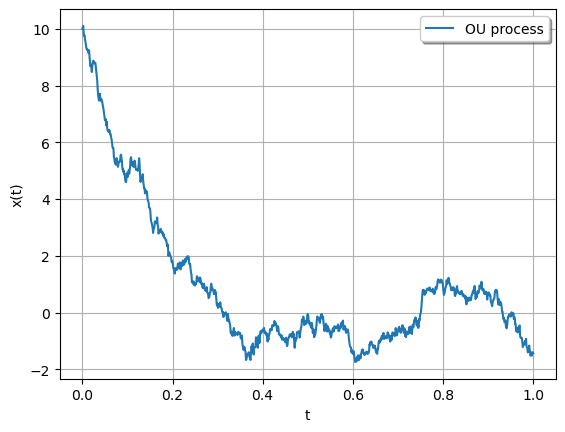

In [4]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

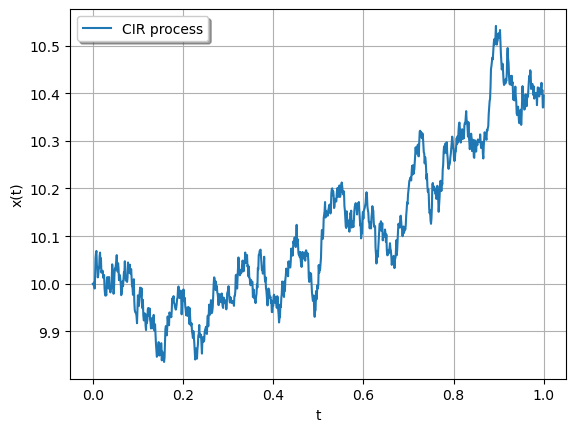

In [5]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

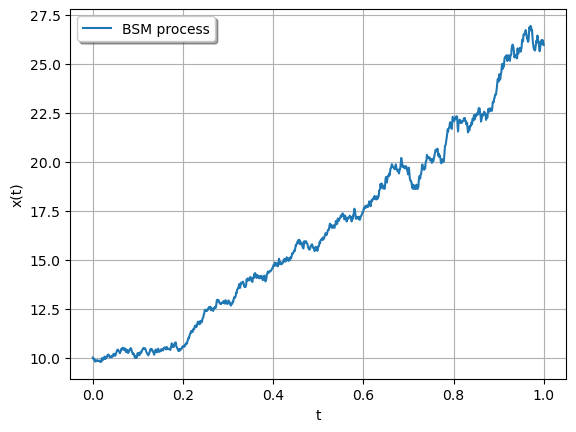

In [6]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [34]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


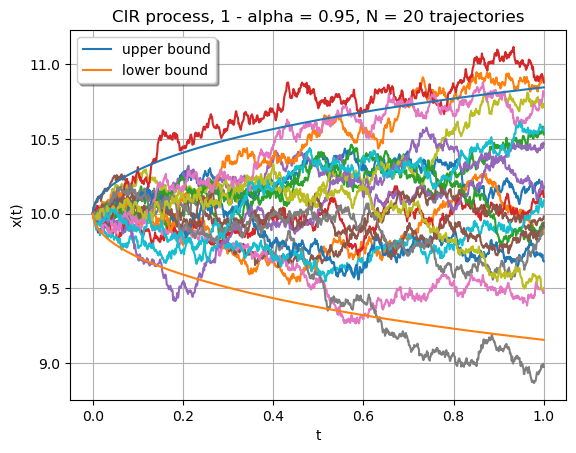

In [35]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


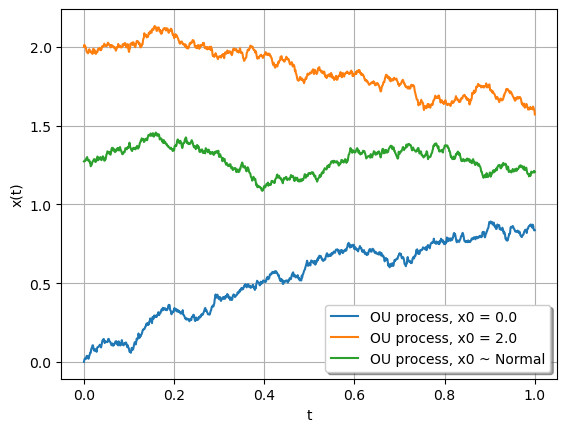

In [36]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

Пусть начальное условие задается как $X_0 \sim \mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$. Это распределение будет являться стационарным для процесса Орнштейна-Уленбека, то есть $X_t$ стремится к распределению $\mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$ при $t \rightarrow \infty$.


Математически это можно объяснить следующим образом: стационарное распределение процесса Орнштейна-Уленбека является $\mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$, что указывает на то, что для любого $t > 0$ распределение $X_t$ будет стремиться к этому распределению. При условии, что $X_0 \sim \mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$, покажем, что $X_t$ действительно сходится к стационарному распределению при $t \rightarrow \infty$. В этом случае, среднее $X_0$ равно $\mu$, а дисперсия $X_0$ — $\frac{\sigma^2}{2\theta}$. Среднее и дисперсия $X_t$ вычисляются следующим образом:


$E(X_t) = e^{-\theta t} X_0 + \mu (1 - e^{-\theta t})$


$\text{Var}(X_t) = \frac{\sigma^2}{2\theta} (1 - e^{-2\theta t})$



Когда $t \rightarrow \infty$, мы имеем $e^{-\theta t} \rightarrow 0$ и $e^{-2\theta t} \rightarrow 0$. Это означает, что $E(X_t) \rightarrow \mu$, а $Var(X_t) \rightarrow \frac{\sigma^2}{2\theta}$. Таким образом, траектория с начальным условием $X_0 \sim \mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$ будет сходиться к стационарному распределению $\mathcal{N}(\mu, \frac{\sigma^2}{2\theta})$.

Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

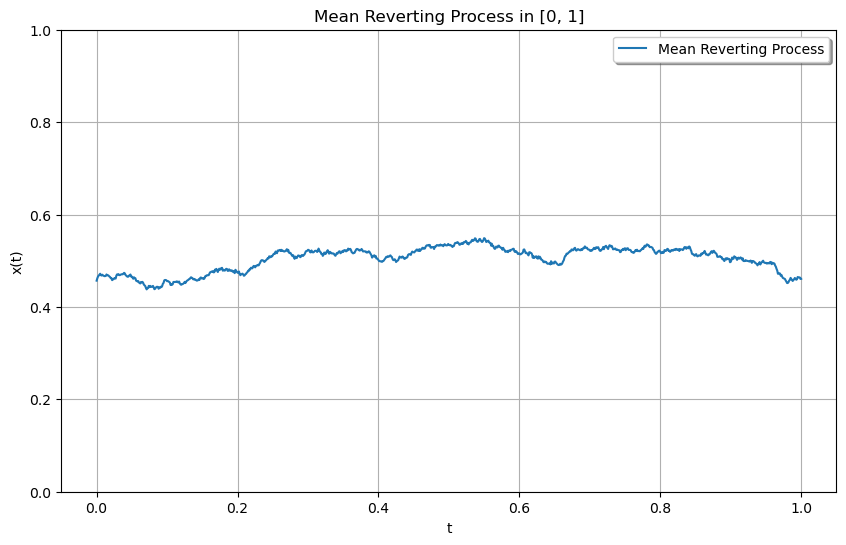

In [23]:
class MeanReversionProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        self.theta = self.params[0]
        self.sigma = self.params[1]

        self.bxt = lambda x: self.theta * (0.5 - x)
        self.sigmaxt = lambda x: self.sigma * x * (1 - x)

    def sampler_init_state(self):
        return np.random.uniform(0, 1, size=self.Nx)

T = 1
Nx = 1
Nt = 1000
theta = 1.0
sigma = 0.3
params = [theta, sigma]

init_state = np.random.uniform(0, 1, size=Nx)

process = MeanReversionProcess(params, T, Nx, Nt, init_state)
t_data, x_data = process.EulerSolution()

plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='Mean Reverting Process')
plt.title('Mean Reverting Process in [0, 1]')
plt.xlabel("t")
plt.ylabel("x(t)")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.ylim(0, 1)
plt.show()


Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.


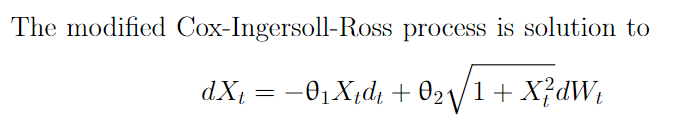

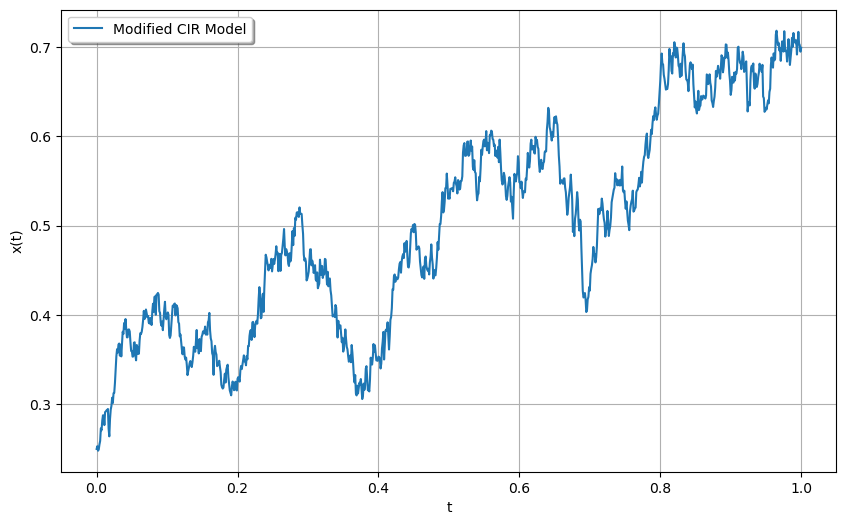

In [39]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        
        # params = [theta1, theta2]
        self.bxt = lambda x: -self.params[0] * x 
        self.sigmaxt = lambda x: self.params[1] * np.sqrt(1 + x**2)

    def sampler_init_state(self):
        return np.ones(self.Nx) * self.params[0] / 2


T = 1
Nx = 1
Nt = 1000
theta1 = 0.5
theta2 = 0.3
params = [theta1, theta2]

process = ModifiedCIRProcess(params, T, Nx, Nt, init_state)
t_data, x_data = process.EulerSolution()

plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='Modified CIR Model')
plt.xlabel("t")
plt.ylabel("x(t)")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


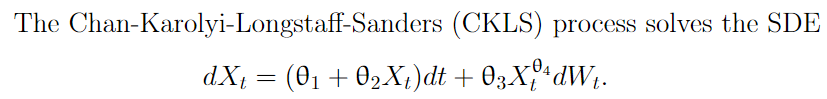

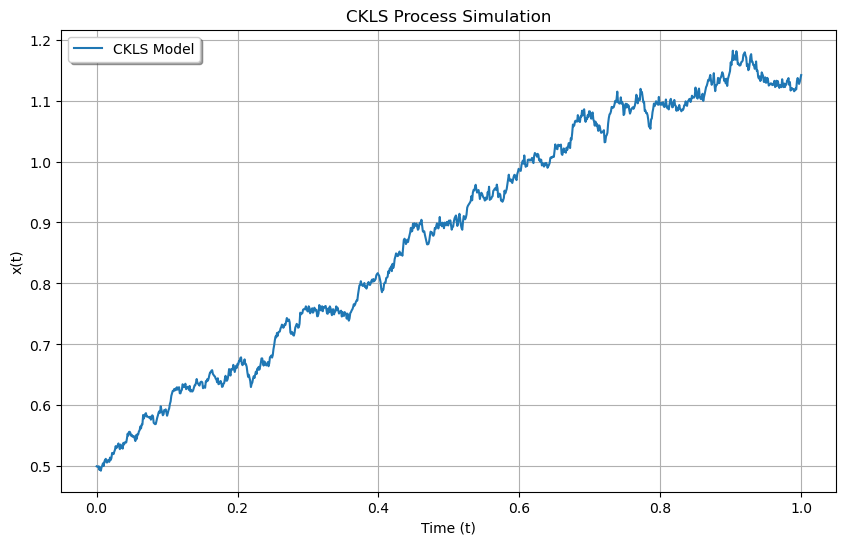

In [38]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        
        # params = [theta1, theta2, theta3, theta4]
        self.bxt = lambda x: self.params[0] + self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * (x ** self.params[3])

    def sampler_init_state(self):
        return np.ones(self.Nx) * self.params[1]
    

T = 1
Nx = 1
Nt = 1000

theta1 = 0.1
theta2 = 0.5
theta3 = 0.2
theta4 = 0.5
params = [theta1, theta2, theta3, theta4]

process = CKLSProcess(params, T, Nx, Nt, init_state)
t_data, x_data = process.EulerSolution()

plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='CKLS Model')
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("CKLS Process Simulation")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

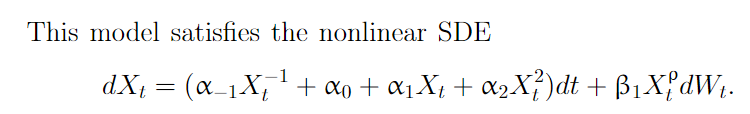

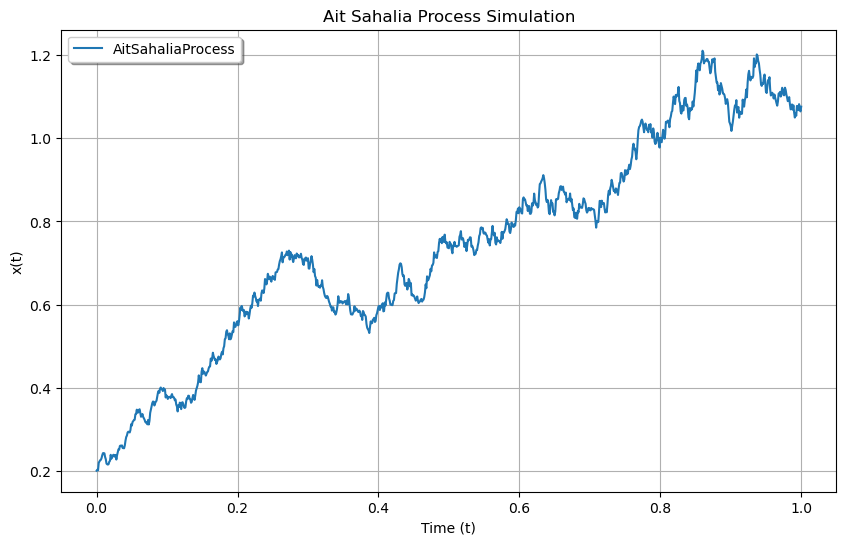

In [42]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [alpha_minus_1, alpha_0, alpha_1, alpha_2, beta_1, rho]
        self.bxt = lambda x: self.params[0] * (x ** -1) + self.params[1] + self.params[2] * x + self.params[3] * (x ** 2)
        self.sigmaxt = lambda x: self.params[4] * (x ** self.params[5])

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[1])
    

alpha_minus_1 = 0.5
alpha_0 = 0.2
alpha_1 = 0.3
alpha_2 = 0.1
beta_1 = 0.4
rho = 0.5
params = [alpha_minus_1, alpha_0, alpha_1, alpha_2, beta_1, rho]

T = 1.0
Nx = 1
Nt = 1000

process = AitSahaliaProcess(params, T, Nx, Nt, init_state)
t_data, x_data = process.EulerSolution()

plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='AitSahaliaProcess')
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Ait Sahalia Process Simulation")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

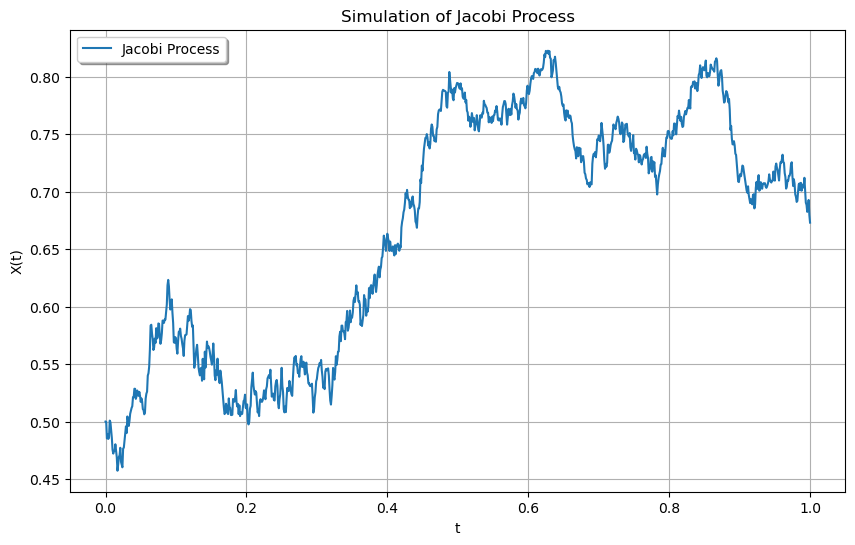

In [46]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta]
        self.bxt = lambda x: -self.params[0] * (x - 0.5)
        self.sigmaxt = lambda x: np.sqrt(self.params[0]) * x * (1 - x)

    def sampler_init_state(self):
        return np.full(self.Nx, 0.5)
    

theta = 1.0

params = [theta]

T = 1.0
Nx = 1
Nt = 1000

jacobi_process = JacobiProcess(params, T, Nx, Nt)
t_data, x_data = jacobi_process.EulerSolution()

plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='Jacobi Process')
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Simulation of Jacobi Process")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


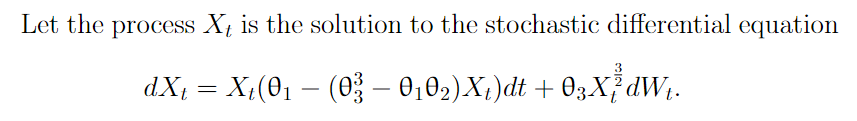

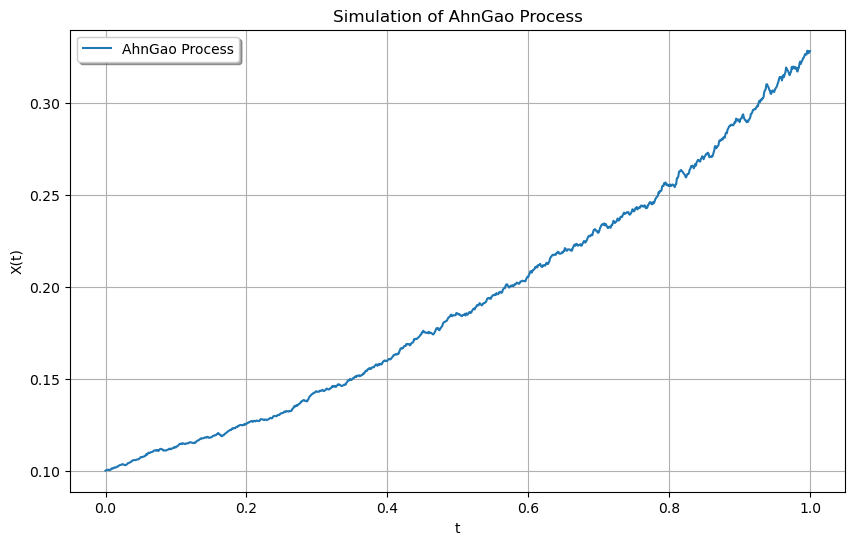

In [48]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: x * (self.params[0] - (self.params[2] - self.params[0] * self.params[1]) * x)
        self.sigmaxt = lambda x: self.params[2] * x**(3/2)

    def sampler_init_state(self):
        return np.ones(self.Nx) * 0.1
    

theta1 = 1.0
theta2 = 0.5
theta3 = 0.2

params = [theta1, theta2, theta3]

T = 1.0
Nx = 1
Nt = 1000

ahn_gao_process = AhnGaoProcess(params, T, Nx, Nt)
t_data, x_data = ahn_gao_process.EulerSolution()


plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='AhnGao Process')
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Simulation of AhnGao Process")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)

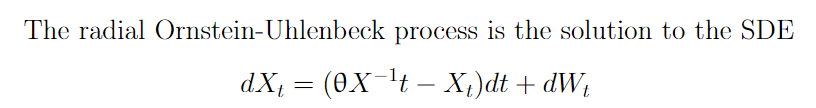

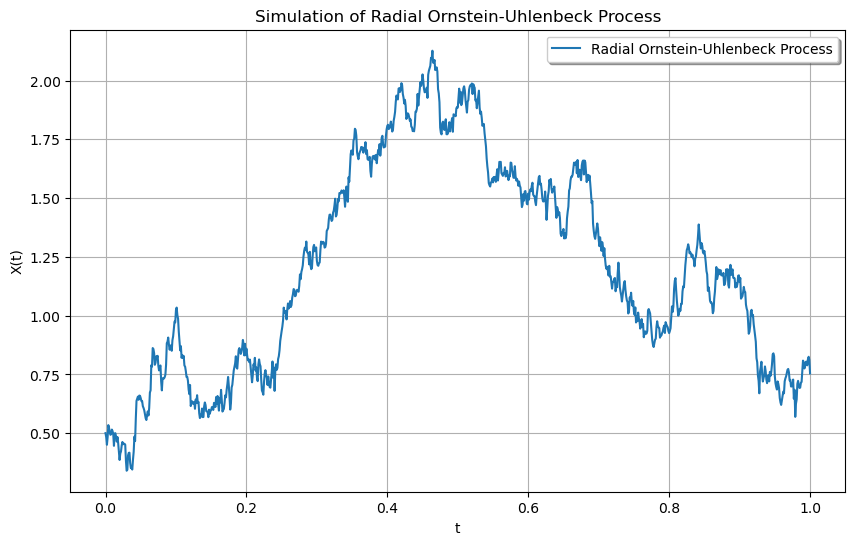

In [50]:
class RadialOrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta]
        self.bxt = lambda x: (self.params[0] - 1) * x
        self.sigmaxt = lambda x: 1.0

    def sampler_init_state(self):
        return np.full(self.Nx, 0.5)
    
theta = 1.0

params = [theta]

T = 1.0
Nx = 1
Nt = 1000


radial_ou_process = RadialOrnsteinUhlenbeckProcess(params, T, Nx, Nt)
t_data, x_data = radial_ou_process.EulerSolution()


plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data, label='Radial Ornstein-Uhlenbeck Process')
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Simulation of Radial Ornstein-Uhlenbeck Process")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [53]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[0] / self.params[1])

    def compute_moments(self, t, n):
        kappa = 1.0
        theta = 0.45
        sigma = 1.0
        X0 = self.init_state[0]

        A_t = np.exp(-kappa * t) * X0 + theta * (1 - np.exp(-kappa * t))
        B_t = sigma * np.exp(-kappa * t)

        max_j = n // 2

        moment = 0.0
        for j in range(max_j + 1):
            moment += (A_t ** (n - 2 * j)) * (B_t ** (2 * j)) * \
                      (0.5 / kappa * (np.exp(2 * kappa * t) - 1)) ** (2 * j)

        return moment

T = 1.0
Nx = 1
Nt = 100000
init_state = np.array([0.5])

theta1 = 0.45
theta2 = 0.2
theta3 = 0.3
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)

n_first_moment = 1
n_second_moment = 2
first_moment = CIRProcess.compute_moments(T, n_first_moment)
second_moment = CIRProcess.compute_moments(T, n_second_moment)

print(f"First Moment (E{{X(t)}}): {first_moment}")
print(f"Second Moment (E{{X^2(t)}}): {second_moment}")


First Moment (E{X(t)}): 0.46839397205857214
Second Moment (E{X^2(t)}): 1.6004907586026225


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.

